# Построение линии регрессии
Линейная регрессия моделирует зависимость цели от признаков как $\hat{y} = \beta_0 + \sum_{j=1}^{p} \beta_j x_j$. Оценки коэффициентов находятся из задачи минимизации суммы квадратов ошибок: $\min_{\beta} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2$. В матричной форме решение (при обратимости) задается $\hat{\beta} = (X^\top X)^{-1} X^\top y$, а качество обычно оценивают по MAE, RMSE и $R^2 = 1 - \frac{\sum (y_i-\hat{y}_i)^2}{\sum (y_i-\bar{y})^2}$.


## Используемые библиотеки
Подключаем стандартные библиотеки для работы с данными (`numpy`, `pandas`), визуализации (`seaborn`, `matplotlib`) и инструменты `sklearn` для загрузки данных, масштабирования, построения пайплайна и метрик.


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [2]:
import warnings
warnings.filterwarnings("ignore")

sns.set_theme(style="whitegrid", palette="deep")
plt.rcParams["figure.dpi"] = 120
PRIMARY_COLOR = "#1f77b4"
SECONDARY_COLOR = "#ff7f0e"
HEATMAP_CMAP = "coolwarm"


## Датасет: описание и частичная распечатка
Датасет **California Housing** из `sklearn` содержит 20 640 блоков переписи населения Калифорнии 1990 года. Каждый объект — усредненные характеристики блока: медианный доход, возраст домов, число комнат, число спален, население, число домохозяйств, широта и долгота. Целевая переменная — **MedHouseVal**: медианная стоимость дома в блоке (в $100 000). Задача — регрессия: предсказать цену по 8 числовым признакам.


In [3]:
housing = fetch_california_housing(as_frame=True)
data = housing.frame
print(f"Размерность: {data.shape}")
data.head()


Размерность: (20640, 9)


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


## Предварительная обработка
Удаляем строки с пропусками (датасет чистый, но привычка хорошая). Отделяем матрицу признаков `X` от целевой переменной `y`. Разбиваем данные на обучающую (80%) и тестовую (20%) выборки с фиксированным `random_state=42` для воспроизводимости. Масштабирование выполняется внутри пайплайна — это гарантирует, что параметры `StandardScaler` вычислены только на обучающих данных.


In [4]:
features = data.drop(columns=["MedHouseVal"])
target = data["MedHouseVal"]

X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.2, random_state=42
)


## Тепловая карта корреляций
Строим матрицу коэффициентов Пирсона. Значения близкие к +1 (темно-красные) указывают на сильную прямую зависимость, близкие к −1 (темно-синие) — на обратную. Обратите внимание, что **MedInc** (медианный доход) имеет наибольшую положительную корреляцию с целевой переменной — это ключевой предиктор. Признаки **Latitude/Longitude** имеют заметную отрицательную корреляцию: цены падают с удалением от побережья.


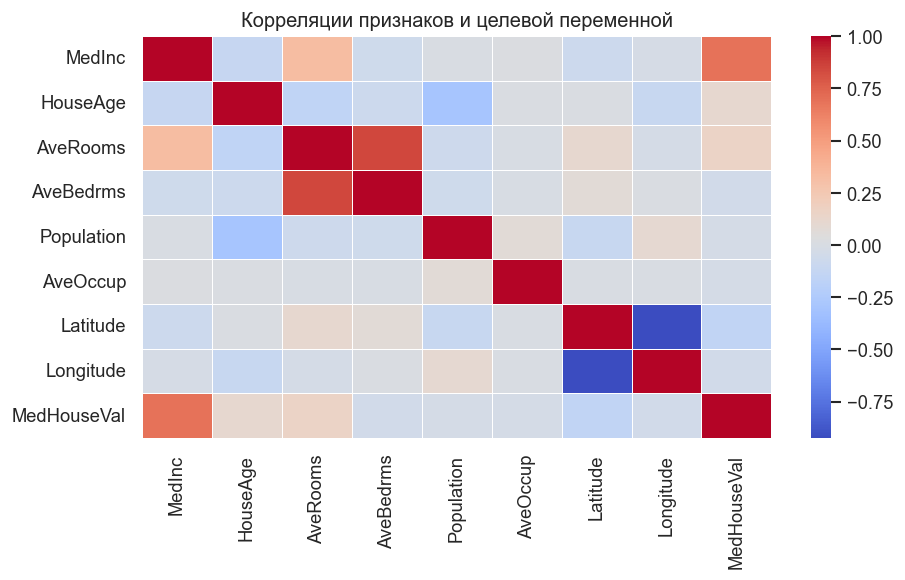

In [5]:
plt.figure(figsize=(8, 5))
correlation = data.corr()
sns.heatmap(correlation, annot=False, cmap=HEATMAP_CMAP, linewidths=0.5)
plt.title("Корреляции признаков и целевой переменной")
plt.tight_layout()
plt.show()


## Обучение модели
Строим `Pipeline` из двух шагов: `StandardScaler` масштабирует признаки до нулевого среднего и единичной дисперсии, `LinearRegression` подбирает оптимальные веса методом МНК. Пайплайн удобен: трансформер `fit_transform` на `X_train` и только `transform` на `X_test`, что исключает утечку данных.


In [6]:
model = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
        ("regressor", LinearRegression()),
    ]
)

model.fit(X_train, y_train)


Pipeline(steps=[('scaler', StandardScaler()),
                ('regressor', LinearRegression())])

## Прогнозы модели
Оцениваем модель на тестовой выборке тремя метриками:
- **MAE** — среднее абсолютное отклонение в $100 000;
- **RMSE** — среднеквадратическое отклонение, чувствительное к выбросам;
- **R²** — доля объясненной дисперсии (1.0 = идеальный прогноз, 0 = модель не лучше среднего).


In [7]:
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("Linear Regression Metrics")
print(f"MAE:  {mae:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"R2:   {r2:.3f}")


Linear Regression Metrics
MAE:  0.533
RMSE: 0.746
R2:   0.576


## Графики выходных результатов
**График 1. Факт vs Прогноз.** Точки вдоль красной диагонали — идеальный прогноз. Отклонения вверх означают завышение, вниз — занижение. Заметна систематическая ошибка при высоких ценах (>4): модель их недооценивает — нелинейный эффект «потолка» цен.

**График 2. Распределение ошибок.** Гистограмма остатков $e_i = y_i - \hat{y}_i$ должна быть симметричной и близкой к нормальной — это условие эффективности МНК. Выраженный скос или тяжёлые хвосты указывают на нелинейность или выбросы.


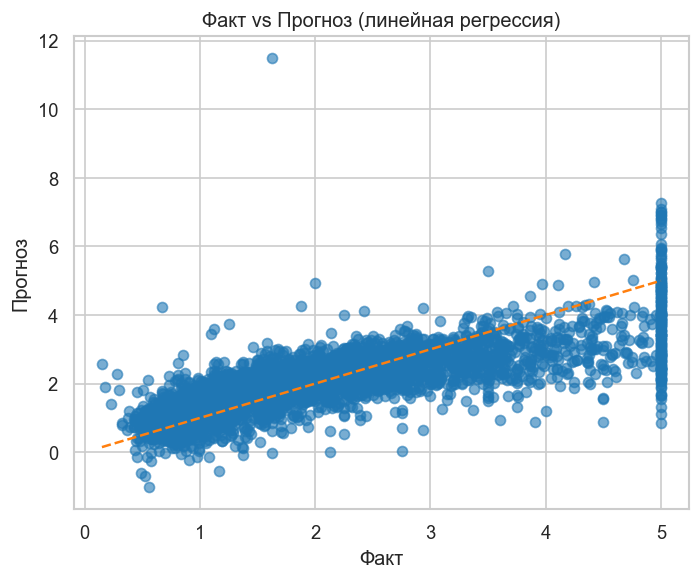

In [8]:
plt.figure(figsize=(6, 5))
plt.scatter(y_test, y_pred, alpha=0.6, color=PRIMARY_COLOR)
plt.plot(
    [y_test.min(), y_test.max()],
    [y_test.min(), y_test.max()],
    color=SECONDARY_COLOR,
    linestyle="--",
)
plt.xlabel("Факт")
plt.ylabel("Прогноз")
plt.title("Факт vs Прогноз (линейная регрессия)")
plt.tight_layout()
plt.show()


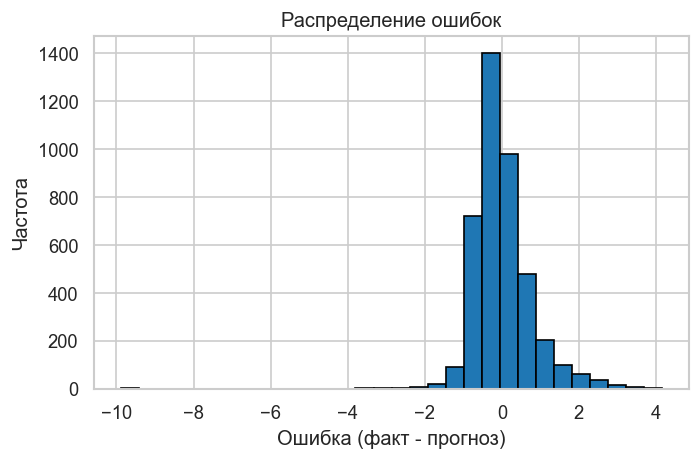

In [9]:
residuals = y_test - y_pred
plt.figure(figsize=(6, 4))
plt.hist(residuals, bins=30, edgecolor="black", color=PRIMARY_COLOR)
plt.xlabel("Ошибка (факт - прогноз)")
plt.ylabel("Частота")
plt.title("Распределение ошибок")
plt.tight_layout()
plt.show()
